In [16]:
# ─── Cell 1: Setup – imports, style, mappings ─────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Seaborn style for academic clarity
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# 2) Display names for metrics
display_names = {
    'flesch_score':         'Flesch Reading Ease',
    'fk_grade':             'Flesch-Kincaid Grade Level',
    'fog_index':            'Gunning Fog Index',
    'smog_index':           'SMOG Index',
    'avg_sentence_length':  'Average Sentence Length',
    'word_count':           'Word Count',
    'passive_ratio':        'Passive Voice Ratio',
    'hedging_percent':      'Hedging Percentage',
    'lexical_density':      'Lexical Density'
}

# 3) Axis labels with units or ranges
axis_labels = {
    'flesch_score':         'Flesch Reading Ease (Score 0–100)',
    'fk_grade':             'Flesch-Kincaid Grade Level (U.S. School Grade)',
    'fog_index':            'Gunning Fog Index (U.S. School Grade)',
    'smog_index':           'SMOG Index (Approx. Years of Education)',
    'avg_sentence_length':  'Average Sentence Length (Words / Sentence)',
    'word_count':           'Word Count (Tokens)',
    'passive_ratio':        'Passive Voice Ratio (0.0–1.0)',
    'hedging_percent':      'Hedging Percentage (0.0–1.0)',
    'lexical_density':      'Lexical Density (% Content Words)'
}

In [ ]:
# ─── Cell 2: Upload the merged CSV ────────────────────────────────────────
from google.colab import files

print("Please upload 'combined_abstracts.csv'")
uploaded = files.upload()  # select your combined_abstracts.csv here

Please upload 'combined_abstracts.csv'


Saving combined_abstracts.csv to combined_abstracts.csv


In [ ]:
# ─── Cell 3: Load data, rename columns, create decades ──────────────────
# 1) Read CSV
df = pd.read_csv('combined_abstracts.csv')

# 2) Rename to snake_case for consistency
rename_map = {
    'Flesch Reading Ease':        'flesch_score',
    'Flesch-Kincaid Grade Level': 'fk_grade',
    'Gunning Fog Index':          'fog_index',
    'SMOG Index':                 'smog_index',
    'Average Sentence Length':    'avg_sentence_length',
    'Word Count':                 'word_count',
    'Passive Voice Ratio':        'passive_ratio',
    'Hedging %':                  'hedging_percent',
    'Lexical Density':            'lexical_density'
}
df.rename(columns=rename_map, inplace=True)

# 3) Bucket years into decades, e.g. 1962 → '1960s'
df['decade'] = (df['Year'] // 10 * 10).astype(int).astype(str) + 's'

In [ ]:
# ─── Cell 4: Inspect column names ────────────────────────────────────────
print("Columns in DataFrame:")
print(df.columns.tolist())

Columns in DataFrame:
['Year', 'Source title', 'Page count', 'Cited by', 'DOI', 'Abstract', 'Publisher', 'Document Type', 'Publication Stage', 'Open Access', 'word_count', 'Sentence Count', 'avg_sentence_length', 'flesch_score', 'fk_grade', 'Syllable Count', 'fog_index', 'Complex Word Count', 'smog_index', 'Hedging Frequency', 'hedging_percent', 'passive_ratio', 'Nominalisation Rate', 'lexical_density', 'Access_Type', 'Subject_Area', 'decade']


In [ ]:
# ─── Cell 5: Define metrics & check availability ─────────────────────────
# 1) List all desired metrics
metrics = list(display_names.keys())

# 2) Filter to existing columns
available = [m for m in metrics if m in df.columns]
missing   = set(metrics) - set(available)
if missing:
    print(f"Missing columns (will skip): {missing}")
print("Metrics to process:", available)

Metrics to process: ['flesch_score', 'fk_grade', 'fog_index', 'smog_index', 'avg_sentence_length', 'word_count', 'passive_ratio', 'hedging_percent', 'lexical_density']


In [ ]:
# ─── Cell 6: Aggregate by decade & access type ───────────────────────────
# 1) Compute mean, median, std
agg_funcs = ['mean','median','std']
agg = df.groupby(['decade','Access_Type'])[available].agg(agg_funcs)

# 2) Flatten MultiIndex cols
agg.columns = ['_'.join(col) for col in agg.columns]
agg_df = agg.reset_index()

# 3) Add sample size (n) & standard error (_se)
counts = df.groupby(['decade','Access_Type']).size().rename('n').reset_index()
agg_df = agg_df.merge(counts, on=['decade','Access_Type'])
for m in available:
    agg_df[f"{m}_se"] = agg_df[f"{m}_std"] / np.sqrt(agg_df['n'])

print("Aggregated table ready:")

Aggregated table ready:


In [ ]:
# ─── Cell 7: Display aggregated stats ─────────────────────────────────────
agg_df.head()

,decade,Access_Type,flesch_score_mean,flesch_score_median,flesch_score_std,fk_grade_mean,fk_grade_median,fk_grade_std,fog_index_mean,fog_index_median,...,n,flesch_score_se,fk_grade_se,fog_index_se,smog_index_se,avg_sentence_length_se,word_count_se,passive_ratio_se,hedging_percent_se,lexical_density_se
0,1960s,C,28.654492,28.66,14.230683,14.296610,13.76,2.943934,17.810000,17.39,...,118,1.310041,0.271011,0.312070,0.270545,0.659920,9.263460,0.022551,0.071287,1.205972
1,1960s,OA,30.790476,27.30,17.516968,14.249048,15.03,3.225677,17.840952,18.94,...,21,3.822516,0.703900,0.833919,0.599837,0.999065,10.616164,0.054302,0.181622,1.776926
2,1970s,C,27.117226,27.34,14.406731,14.509483,14.32,2.933757,18.037503,17.94,...,793,0.511598,0.104181,0.120836,0.102248,0.223597,3.322375,0.007956,0.026792,0.415643
3,1970s,OA,31.190312,34.48,11.575171,13.699375,12.67,2.406941,17.227812,16.40,...,32,2.046220,0.425491,0.462515,0.331501,0.858340,20.642405,0.046998,0.210242,2.568737
4,1980s,C,25.500886,26.27,16.296184,14.845820,14.58,3.373500,18.376145,18.21,...,1603,0.407023,0.084259,0.093959,0.074206,0.154720,2.006164,0.005397,0.019414,0.260011


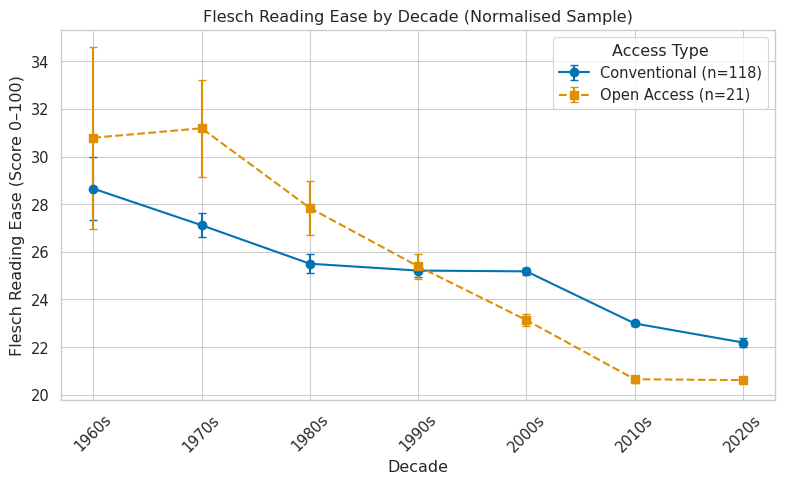

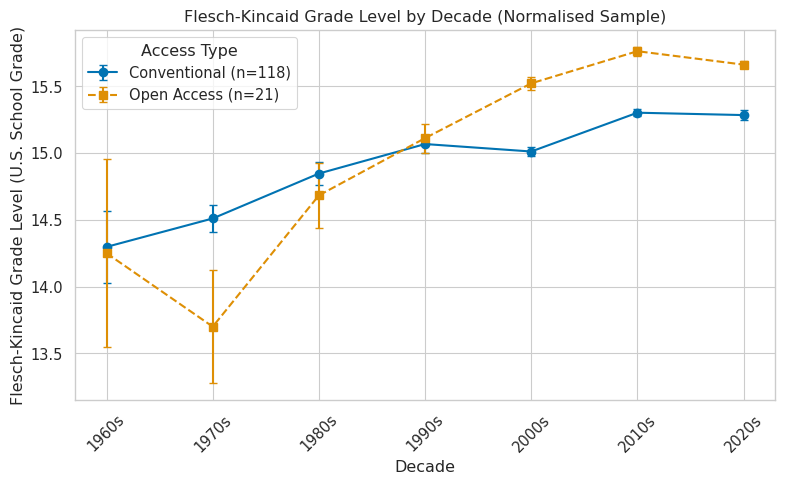

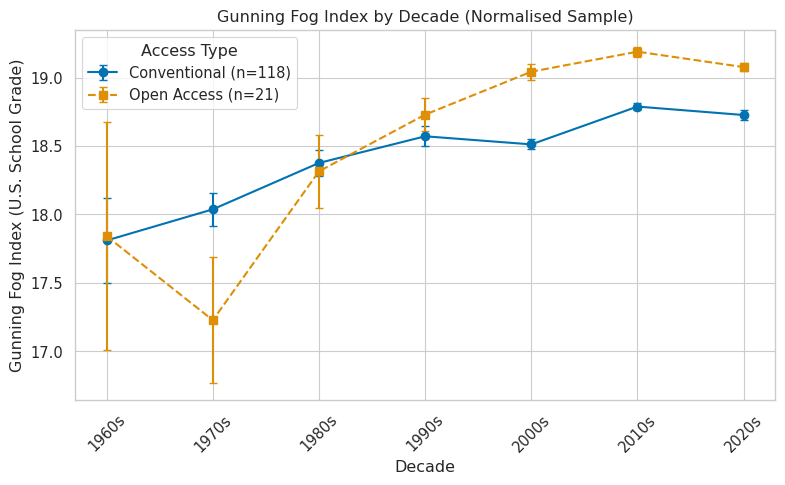

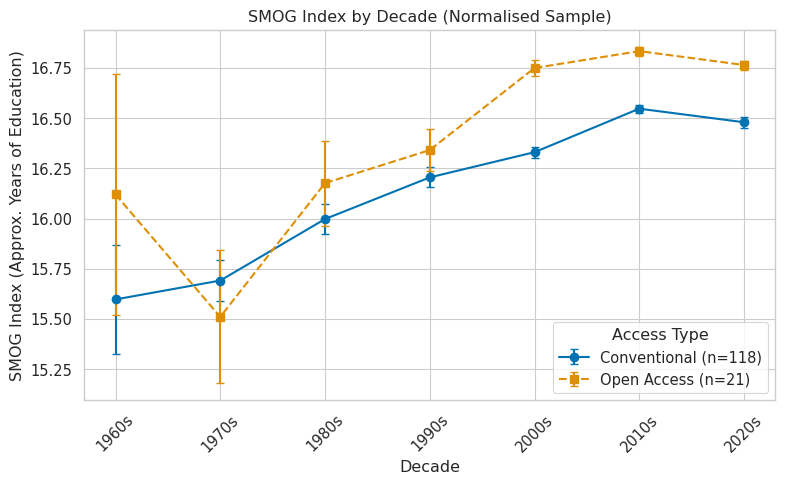

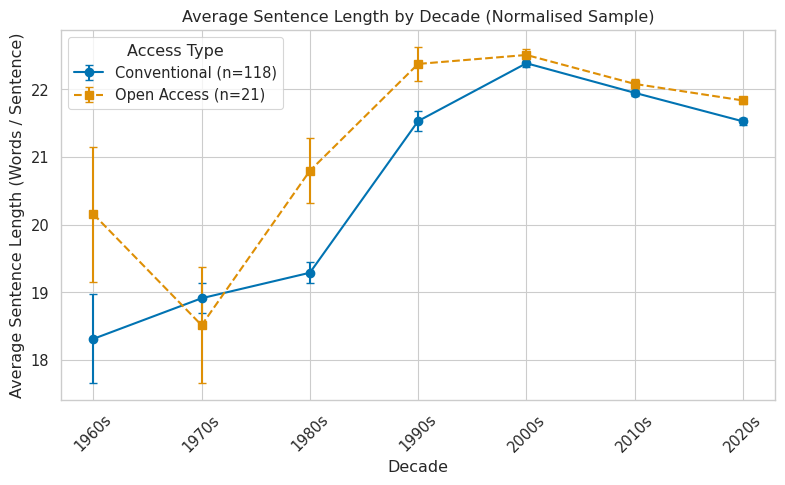

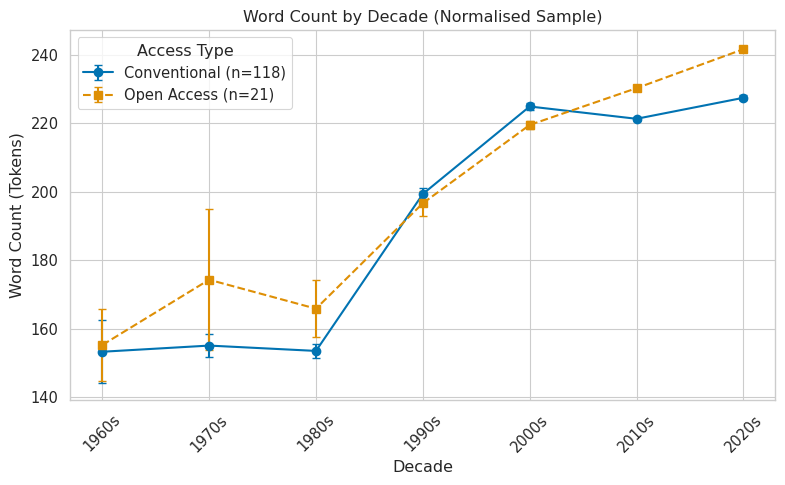

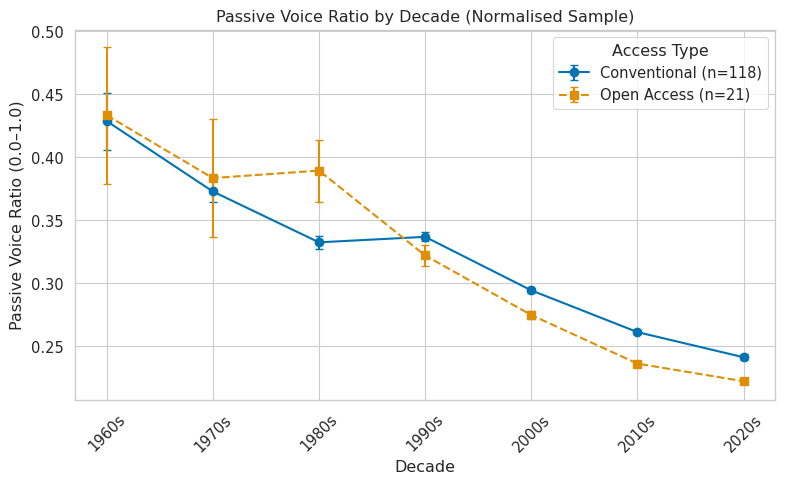

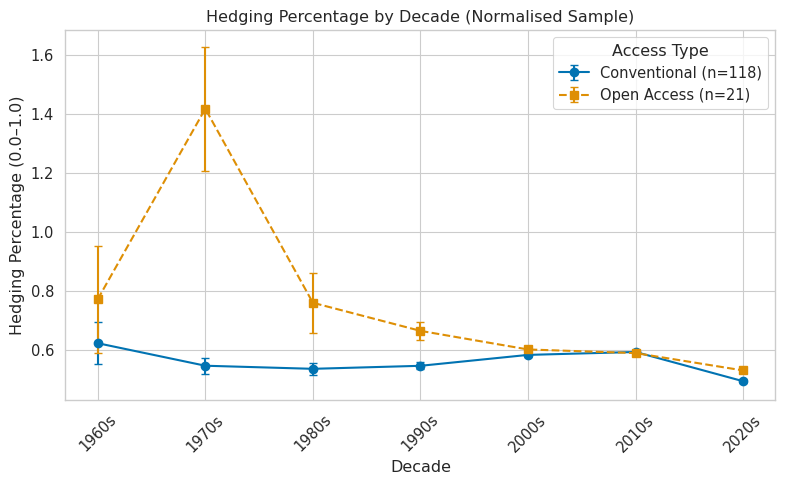

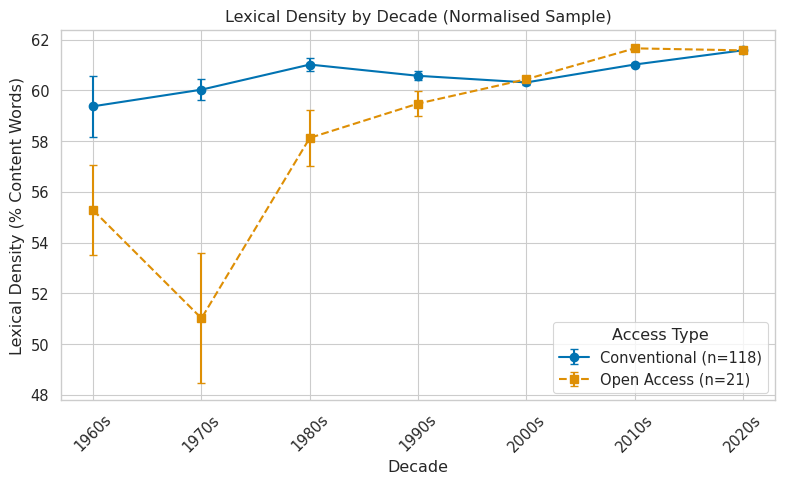

In [17]:
# ─── Cell 8: Trend lines with SE error bars ──────────────────────────────
decades = sorted(agg_df['decade'].unique(), key=lambda d: int(d[:-1]))

for m in available:
    plt.figure(figsize=(8,5))
    for atype, style, marker in zip(['C','OA'], ['-', '--'], ['o','s']):
        sub = agg_df[agg_df['Access_Type']==atype].set_index('decade').loc[decades]
        x    = np.arange(len(decades))
        y    = sub[f"{m}_mean"]
        yerr = sub[f"{m}_se"]  # standard error

        label = ("Conventional" if atype=='C' else "Open Access")
        plt.errorbar(
            x, y, yerr=yerr,
            fmt=style+marker,
            capsize=3,
            linewidth=1.5,
            markersize=6,
            label=f"{label} (n={sub['n'].iloc[0]})"
        )
    plt.xticks(x, decades, rotation=45)
    plt.xlabel('Decade')
    plt.ylabel(axis_labels[m])
    plt.title(f"{display_names[m]} by Decade (Normalised Sample)")
    plt.legend(title="Access Type", frameon=True)
    plt.tight_layout()
    # Save high-res
    plt.savefig(f"{m}_trend.png", dpi=300)
    plt.savefig(f"{m}_trend.svg")
    plt.show()

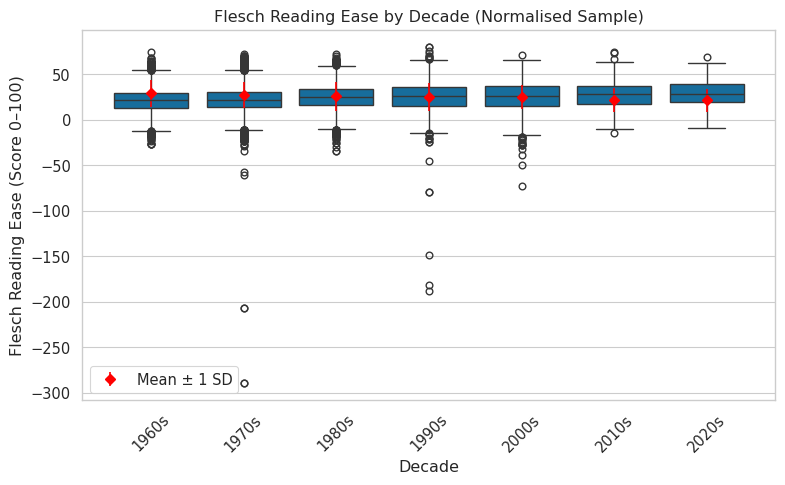

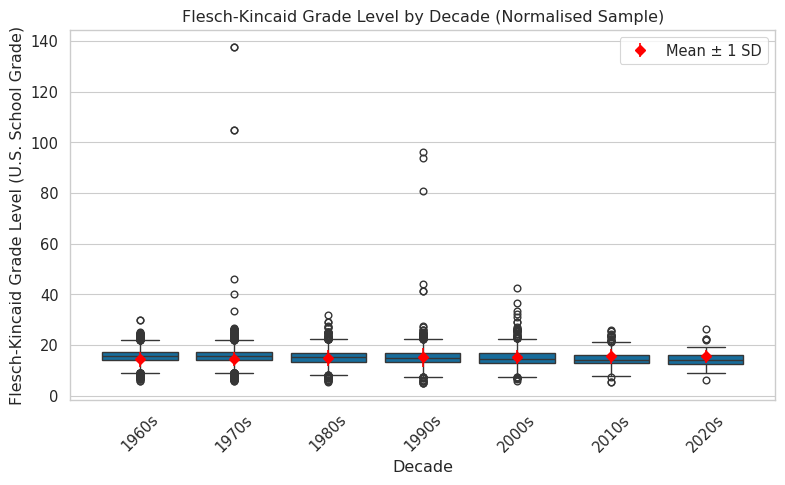

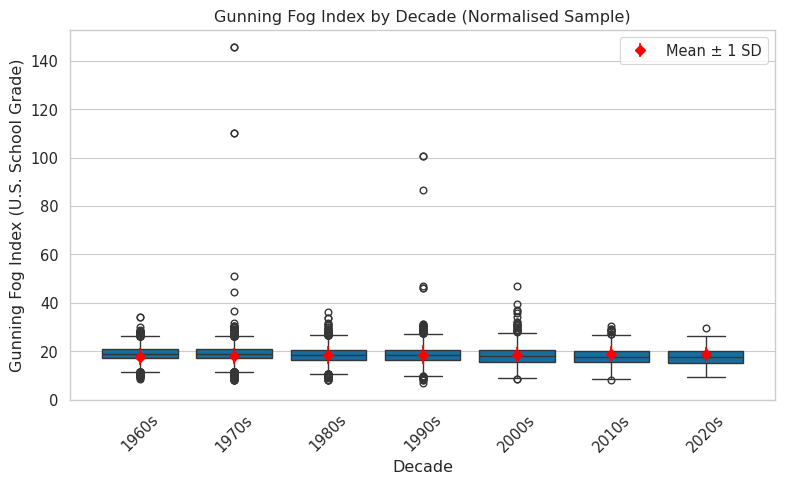

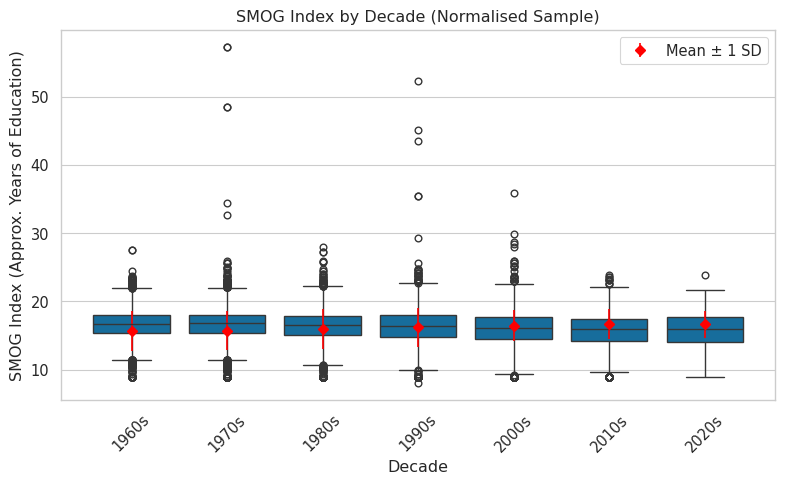

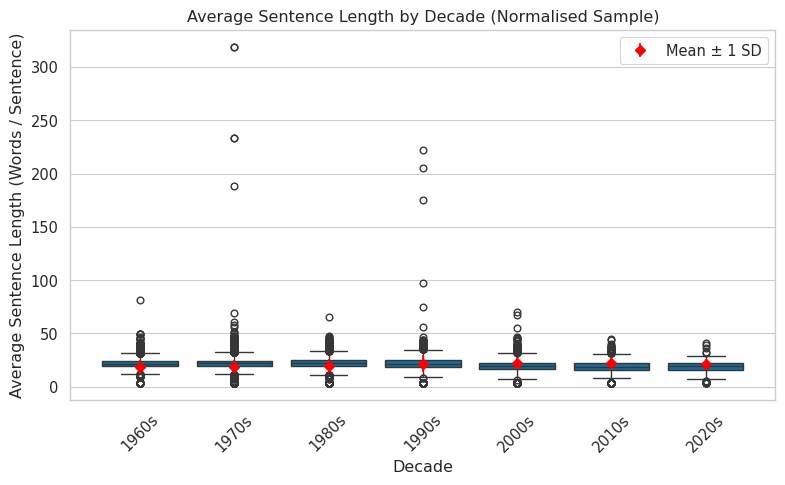

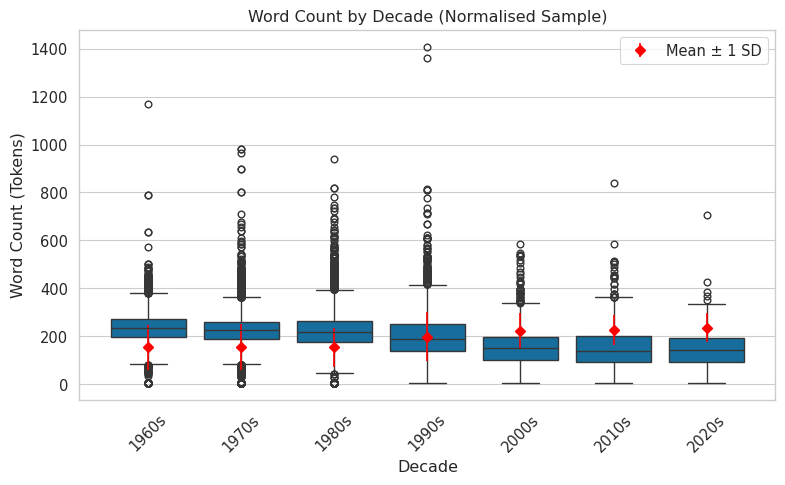

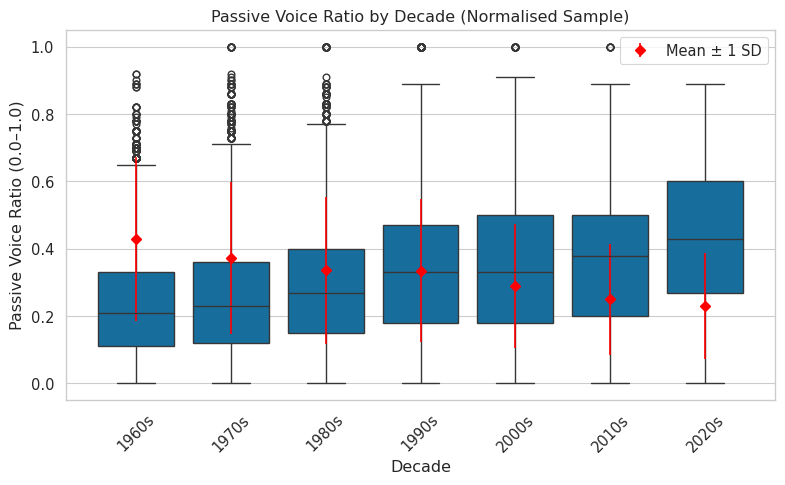

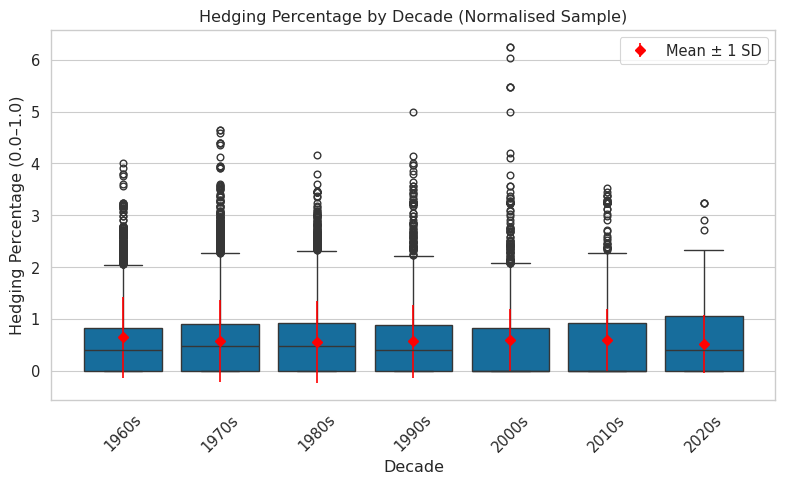

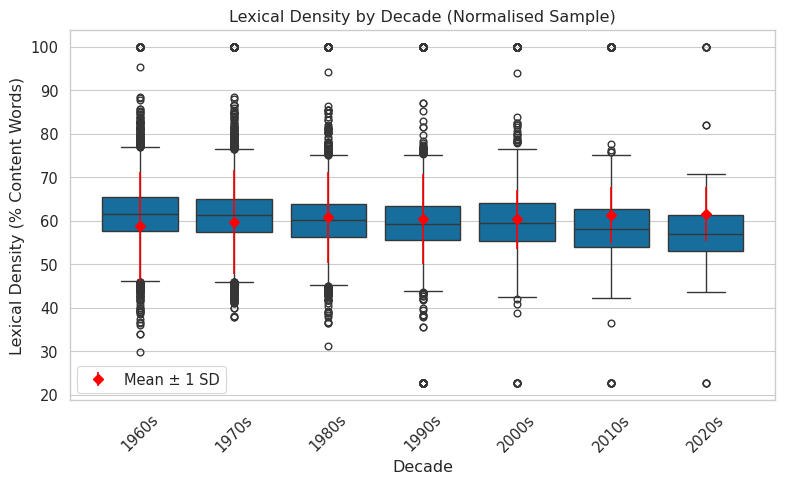

In [18]:
# ─── Cell 9: Boxplots by Decade (SD overlay & mean marker) ──────────────
for m in available:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='decade', y=m, data=df, showfliers=True)

    # Overlay mean ± 1 SD
    stats = df.groupby('decade')[m].agg(['mean','std'])
    x_pos = np.arange(len(decades))
    plt.errorbar(
        x_pos,
        stats.loc[decades,'mean'],
        yerr=stats.loc[decades,'std'],
        fmt='D', color='red',
        markersize=5, label='Mean ± 1 SD'
    )

    plt.xticks(x_pos, decades, rotation=45)
    plt.xlabel('Decade')
    plt.ylabel(axis_labels[m])
    plt.title(f"{display_names[m]} by Decade (Normalised Sample)")
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig(f"{m}_box_decade.png", dpi=300)
    plt.show()

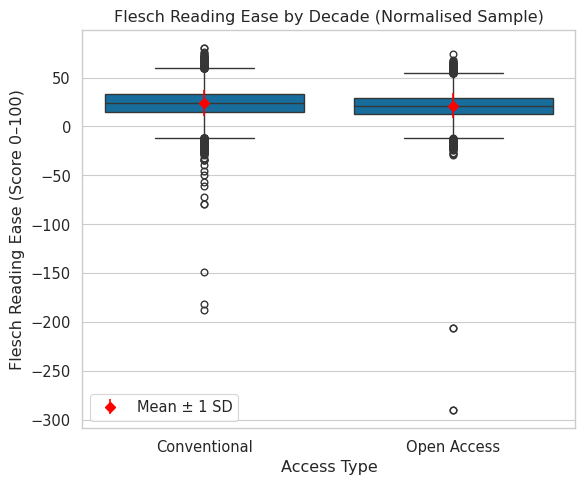

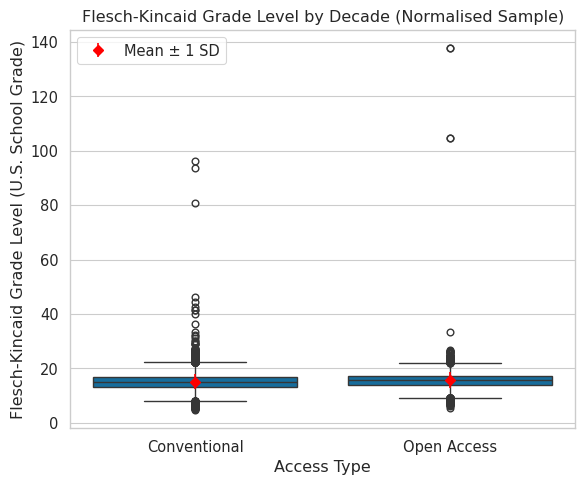

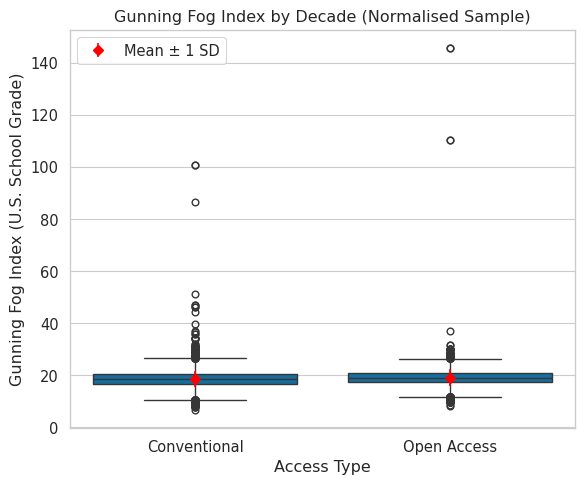

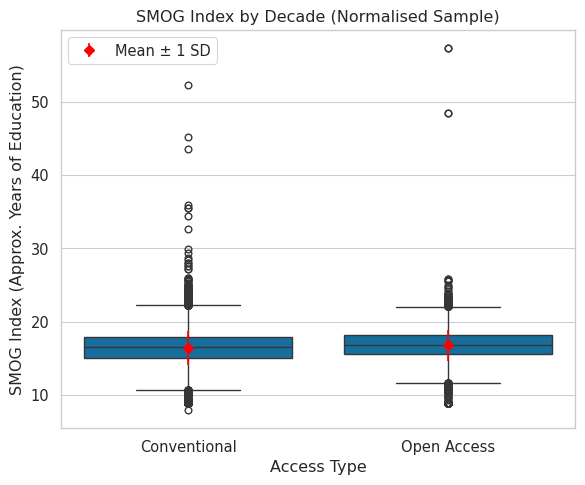

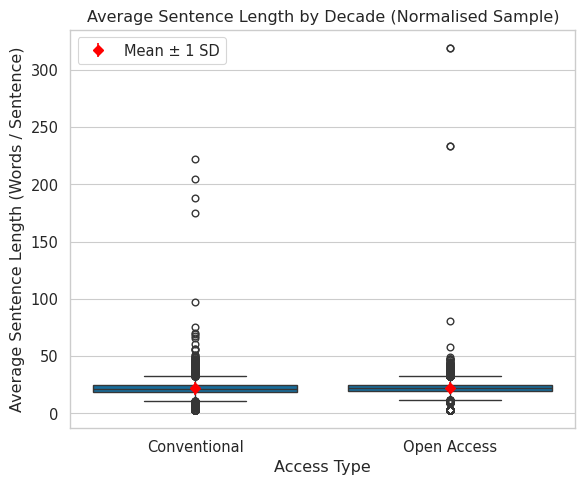

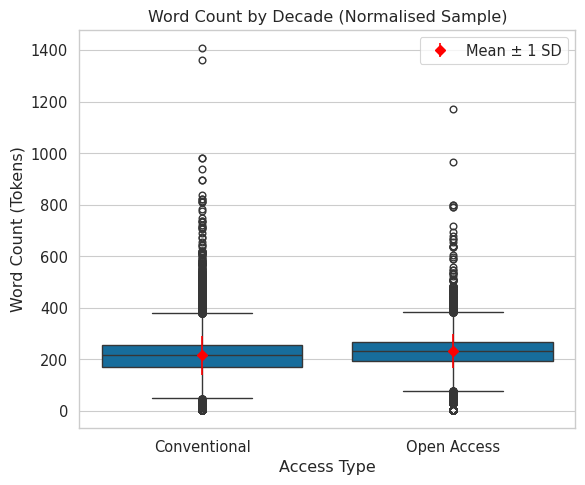

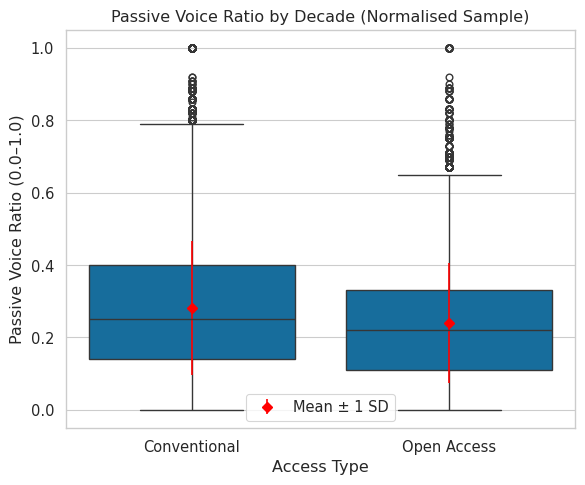

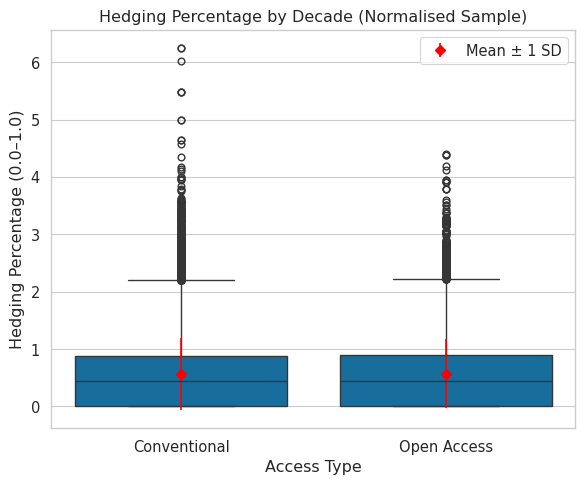

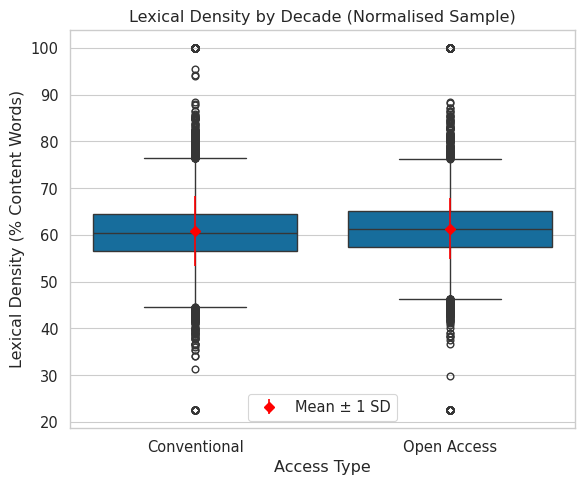

In [19]:
# ─── Cell 10: Boxplots by Access Type (SD overlay & mean marker) ─────────
order = ['C','OA']
for m in available:
    plt.figure(figsize=(6,5))
    sns.boxplot(x='Access_Type', y=m, data=df, order=order, showfliers=True)

    # Overlay mean ± 1 SD
    stats = df.groupby('Access_Type')[m].agg(['mean','std'])
    x_pos = [0,1]  # C, OA
    plt.errorbar(
        x_pos,
        stats.loc[order,'mean'],
        yerr=stats.loc[order,'std'],
        fmt='D', color='red',
        markersize=5, label='Mean ± 1 SD'
    )

    plt.xticks(x_pos, ['Conventional','Open Access'])
    plt.xlabel('Access Type')
    plt.ylabel(axis_labels[m])
    plt.title(f"{display_names[m]} by Decade (Normalised Sample)")
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig(f"{m}_box_access.png", dpi=300)
    plt.show()

In [ ]:
# ─── Cell 12: Academic Graph Formatting Best Practices ────────────────────
1. **Consistent Typography**: Use the same font family and size across all figures.
2. **Colorblind-Friendly Palette**: “colorblind” palette ensures accessibility in print and digital.
3. **Clear Gridlines**: Light gridlines (Seaborn’s whitegrid) aid reading without clutter.
4. **Legends & Labels**: Spell out “Conventional” and “Open Access” to avoid confusion.
5. **Error-Bars vs. Variability**:
   - **Trend Lines** use Standard Error (precision of the mean) when sample size varies.
   - **Boxplots** display Standard Deviation to illustrate within-decade spread.
6. **High-Resolution Exports**: Save both PNG (≥300 dpi) and SVG for vector clarity in journals.
7. **Even Axis Spacing**: Decades are evenly spaced and chronologically ordered on the x-axis.
8. **Overlay Summary Stats**: Mean markers on boxplots complement the median line for full context.
9. **Caption Templates**: Always define what error bars represent (±1 SE or ±1 SD) and sample size.

*Feel free to adjust font scales, marker sizes, or line widths according to your target journal’s guidelines.*